In [21]:
import numpy as np
import pandas as pd
import os

#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.5.0


[]

In [97]:
data = pd.read_csv("./data/data3a.csv")
data

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C
...,...,...,...
95,8,9.15,T
96,6,8.52,T
97,8,10.24,T
98,7,10.86,T


In [85]:
type(data.f[0])

str

In [23]:
data.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


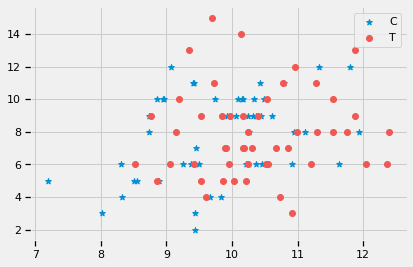

In [24]:
plt.scatter(data[data.f == "C"].x, data[data.f == "C"].y, marker="*", label="C")
plt.scatter(data[data.f == "T"].x, data[data.f == "T"].y, marker="o", c=TFColor[0], label="T")
plt.legend()
plt.show()

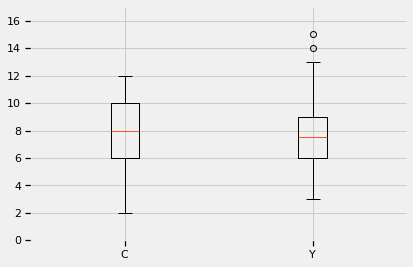

In [25]:
fig, axes = plt.subplots()
axes.boxplot((data[data.f == "C"].y, data[data.f == "T"].y))
axes.set_xticklabels(['C', 'Y'])
plt.ylim([0, 17])
plt.show()

# GLM??

https://www.slideshare.net/logics-of-blue/2-3glm?next_slideshow=1

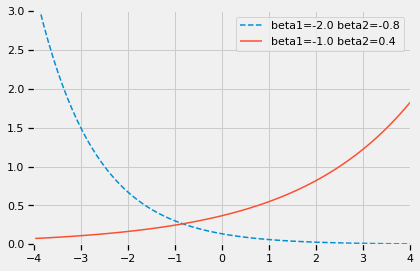

In [26]:
def linear_predictor(beta_1, beta_2, x):
    return np.exp(beta_1 + beta_2 * x)

def link_function(beta_1, beta_2, x):
    return np.log(linear_predictor(beta_1, beta_2, x))

beta_1 = -2
beta_2 = -0.8
xs = np.linspace(-5., 5, 100)
lambdas_1 = linear_predictor(beta_1, beta_2, xs)

beta_1 = -1
beta_2 = 0.4
lambdas_2 = linear_predictor(beta_1, beta_2, xs)

plt.plot(xs, lambdas_1, linestyle="--", label="beta1=%.1f beta2=%.1f" %(-2, -0.8))
plt.plot(xs, lambdas_2, linestyle="-", label="beta1=%.1f beta2=%.1f" %(-1, 0.4))
plt.ylim(0., 3.)
plt.xlim(-4., 4.)
plt.legend()
plt.show()



In [27]:
import contextlib
import functools
import time

@contextlib.contextmanager
def timed_execution():
  t0 = time.time()
  yield
  dt = time.time() - t0
  print('Evaluation took: %f seconds' % dt)

def make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad

def np_value(tensor):
  """Get numpy value out of possibly nested tuple of tensors."""
  if isinstance(tensor, tuple):
    return type(tensor)(*(np_value(t) for t in tensor))
  else:
    return tensor.numpy()

def run(optimizer):
  """Run an optimizer and measure it's evaluation time."""
  optimizer()  # Warmup.
  with timed_execution():
    result = optimizer()
  return np_value(result)

## まずは、体サイズxについて。

### tfp.optimizer

In [81]:
@make_val_and_grad_fn
def logl(x):
    # mean = tf.math.log(tf.math.exp(x[0] + x[1] * data.x))
    mean = tf.math.exp(x[0] + x[1] * data.x)
    # mean = x[0] + x[1] * data.x
    dist = tfd.Poisson(rate=mean)
    logl = -tf.reduce_sum(dist.log_prob(data.y))
    return logl

dim = 2

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results.converged)
print('Location of the minimum:', results.position) 
print('Number of iterations:', results.num_iterations)

Evaluation took: 0.021847 seconds
L-BFGS Results
From: [-0.00209124  0.4609274 ]
Converged: True
Location of the minimum: [1.2917215  0.07566186]
Number of iterations: 10


In [56]:
# position          : A tensor containing the last argument value found during the search. If the search converged, then this value is the argmin of the objective function.
# objective_value   : A tensor containing the value of the objective function at the position. If the search converged, then this is the (local) minimum of the objective function. 
# objective_gradient: A tensor containing the gradient of the objective function at the position. If the search converged the max-norm of this tensor should be below the tolerance. 
results

LBfgsOptimizerResults(converged=True, failed=False, num_iterations=10, num_objective_evaluations=59, position=array([1.2917205 , 0.07566195], dtype=float32), objective_value=235.38626, objective_gradient=array([1.2636185e-05, 1.9073486e-04], dtype=float32), position_deltas=array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.22357190e-01, -1.29554439e+00],
       [ 9.16557163e-02,  9.34325695e-01],
       [ 5.60975075e-03,  5.69476932e-02],
       [ 4.21169400e-03,  4.16534990e-02],
       [ 1.32146478e-03,  1.17783844e-02],
       [ 1.94564462e-04,  2.96592712e-04],
       [ 1.29440641e+00, -1.22351445e-01],
       [ 1.37487411e-01, -1.63427442e-02],
       [ 8.01610947e-03, -7.23309815e-04]], dtype=float32), gradient_deltas=array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.07559297e+04, -1.13554984e+05],
       [ 2.45759155e+02,  2.50534912e+03],
       [ 1.96625610e+02,  2.02984644e+03],
       [ 2.39120087e+02,  2.48000000e+03],
       [ 8.89195633e+01,  9.24456421e+02],
     

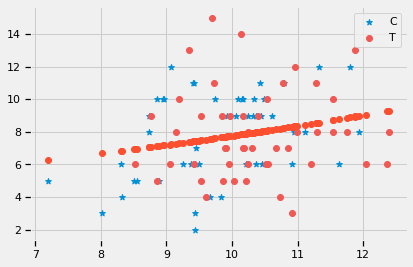

In [59]:
lambdas = np.exp(results.position[0] + results.position[1] * data.x)

plt.scatter(data[data.f == "C"].x, data[data.f == "C"].y, marker="*", label="C")
plt.scatter(data[data.f == "T"].x, data[data.f == "T"].y, marker="o", c=TFColor[0], label="T")
plt.scatter(data.x, lambdas)
plt.legend()
plt.show()

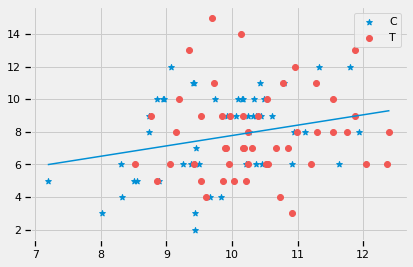

In [45]:
xx = np.linspace(np.min(data.x), np.max(data.x), 100)
lambdas = results.position[0] + results.position[1] * xx

plt.scatter(data[data.f == "C"].x, data[data.f == "C"].y, marker="*", label="C")
plt.scatter(data[data.f == "T"].x, data[data.f == "T"].y, marker="o", c=TFColor[0], label="T")  
plt.plot(xx, lambdas)
plt.legend()
plt.show()

### tfp.GLM

In [39]:
x = np.expand_dims(data.x.to_numpy(), axis=1)
y = data.y.to_numpy().astype(float)
print(x.shape)
print(y.shape)

(100, 1)
(100,)


In [40]:

# model_matrix: (Batch of) float-like, matrix-shaped Tensor where each row represents a sample's features.
# response    : (Batch of) vector-shaped Tensor where each element represents a sample's observed response (to the corresponding row of features). Must have same dtype as model_matrix.
@tf.function(autograph=False)
def fit_model():
  model_coefficients, linear_response, is_converged, num_iter = tfp.glm.fit(
      model_matrix=x, response=y, model=tfp.glm.Poisson())
  log_likelihood = tfp.glm.Poisson().log_prob(y, linear_response)
  return (model_coefficients, linear_response, is_converged, num_iter,
          log_likelihood)

[model_coefficients, linear_response, is_converged, num_iter, log_likelihood] = [t.numpy() for t in fit_model()]          
# model_coefficients       : (Batch of) vector-shaped Tensor; represents the fitted model coefficients, one for each column in model_matrix.
# predicted_linear_response: response-shaped Tensor representing linear predictions based on new model_coefficients, i.e., tf.linalg.matvec(model_matrix, model_coefficients) + offset. 

print(('is_converged: {}\n'
       '    num_iter: {}\n'
       '    accuracy: {}\n'
       '    deviance: {}'
      ).format(
    is_converged,
    num_iter,
    np.mean((linear_response > 0.) == y),
    2. * np.mean(log_likelihood)
    ))

is_converged: True
    num_iter: 10
    accuracy: 0.0
    deviance: -4.832395201147304


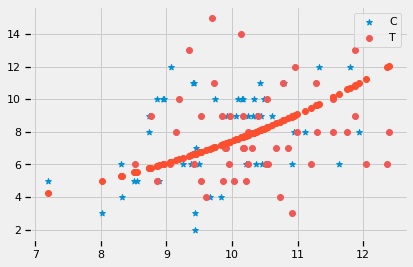

In [203]:
lambdas = np.exp(linear_response)

plt.scatter(data[data.f == "C"].x, data[data.f == "C"].y, marker="*", label="C")
plt.scatter(data[data.f == "T"].x, data[data.f == "T"].y, marker="o", c=TFColor[0], label="T")
plt.scatter(data.x, lambdas)
plt.legend()
plt.show()

In [83]:
print(np.exp(1.26 + 0.08 - 0.032))
print(np.exp(1.26) * np.exp(0.08) * np.exp(-0.032))

3.6987687721941076
3.6987687721941085


## 施肥効果f (Rでの因子型) が説明変数、y（種子数）が応答変数の場合

neg log likelihood が 237.6273 になるはず

In [155]:
data = pd.read_csv("./data/data3a.csv")
data.dtypes

y      int64
x    float64
f     object
dtype: object

In [156]:
data.f.replace("C", 0, inplace=True)
data.f.replace("T", 1, inplace=True)
data

,y,x,f
0,6,8.31,0
1,6,9.44,0
2,6,9.50,0
3,12,9.07,0
4,10,10.16,0
...,...,...,...
95,8,9.15,1
96,6,8.52,1
97,8,10.24,1
98,7,10.86,1


In [157]:
data.astype({"f": "int64"})
data.dtypes

y      int64
x    float64
f      int64
dtype: object

In [158]:
type(data.f[0])

numpy.int64

In [118]:
@make_val_and_grad_fn
def logl(x):
    mean = tf.math.exp(x[0] + x[1] * data.f)
    dist = tfd.Poisson(rate=mean)
    logl = -tf.reduce_sum(dist.log_prob(data.y))
    return logl

dim = 2

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results.converged)
print('Location of the minimum:', results.position) 
print('Number of iterations:', results.num_iterations)
print("objective_value:", results.objective_value)

Evaluation took: 0.024485 seconds
L-BFGS Results
From: [0.93263377 1.69597372]
Converged: True
Location of the minimum: [2.0515563  0.01277157]
Number of iterations: 10
objective_value: 237.6273


## 施肥効果f (Rでの因子型) と体サイズ(x)が説明変数、y（種子数）が応答変数の場合

### 対数リンク関数

In [164]:
@make_val_and_grad_fn
def logl(x):
    mean = tf.math.exp(x[0] + x[1] * data.x + x[2] * data.f)
    dist = tfd.Poisson(rate=mean)
    logl = -tf.reduce_sum(dist.log_prob(data.y))
    return logl

dim = 3

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results_exp = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results_exp.converged)
print('Location of the minimum:', results_exp.position) 
print('Number of iterations:', results_exp.num_iterations)
print("objective_value:", results_exp.objective_value)

Evaluation took: 0.028746 seconds
L-BFGS Results
From: [-0.28797032  1.02740369 -1.32376353]
Converged: True
Location of the minimum: [ 1.2631047   0.08007263 -0.031999  ]
Number of iterations: 14
objective_value: 235.29373


### 恒等リンク関数

In [168]:
@make_val_and_grad_fn
def logl(x):
    mean = x[0] + x[1] * data.x + x[2] * data.f
    dist = tfd.Poisson(rate=mean)
    logl = -tf.reduce_sum(dist.log_prob(data.y))
    return logl

dim = 3

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results_eq = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results_eq.converged)
print('Location of the minimum:', results_eq.position) 
print('Number of iterations:', results_eq.num_iterations)
print("objective_value:", results_eq.objective_value)

Evaluation took: 0.019972 seconds
L-BFGS Results
From: [-0.46745979  0.62936033 -0.79809823]
Converged: True
Location of the minimum: [ 1.2670722   0.6606442  -0.20475435]
Number of iterations: 10
objective_value: 235.159


### 比較

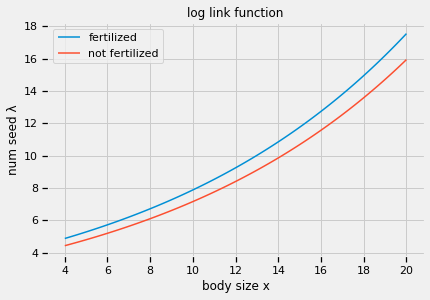

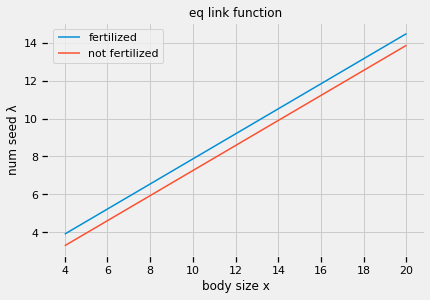

In [184]:
xx_f0 = np.linspace(4, 20, 100)
xx_f1 = np.linspace(4, 20, 100)

# log & f = c(0)
log_data_f0_res = np.exp(results_exp.position[0]) * np.exp(results_exp.position[1] * xx_f0)
log_data_f1_res = np.exp(results_exp.position[0]) * np.exp(results_exp.position[1] * xx_f1) * np.exp(results_exp.position[2] * 3. * 1)
plt.plot(xx_f0, log_data_f0_res, label="fertilized")
plt.plot(xx_f1, log_data_f1_res, label="not fertilized")
plt.xlabel("body size x")
plt.ylabel("num seed λ")
plt.legend()
plt.title("log link function")
plt.show()

# eq & f = t(1)
log_data_f0_res = results_eq.position[0] + results_eq.position[1] * xx_f0 + results_eq.position[2] * 3 * 0.
log_data_f1_res = results_eq.position[0] + results_eq.position[1] * xx_f1 + results_eq.position[2] * 3 * 1.
plt.plot(xx_f0, log_data_f0_res, label="fertilized")
plt.plot(xx_f1, log_data_f1_res, label="not fertilized")
plt.xlabel("body size x")
plt.ylabel("num seed λ")
plt.legend()
plt.title("eq link function")
plt.show()


## なんでも正規分布？

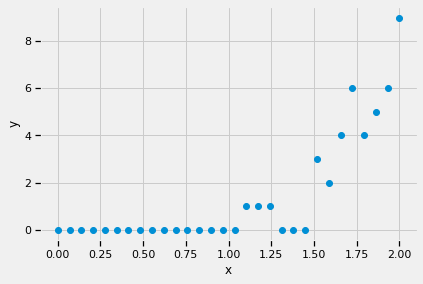

In [225]:
xx = np.linspace(0., 2., 30)
yy = tfd.Poisson(rate=np.exp(-4. + 3. * xx)).sample(1).numpy().sum(axis=0)

plt.scatter(xx, yy)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### 正規分布　＆　恒等関数

In [236]:
@make_val_and_grad_fn
def logl(x):
    mean = x[0] + x[1] * xx
    dist = tfd.Normal(loc=mean, scale=1)
    logl = -tf.reduce_sum(dist.log_prob(yy))
    return logl

dim = 2

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results_norm_eq = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results_norm_eq.converged)
print('Location of the minimum:', results_norm_eq.position) 
print('Number of iterations:', results_norm_eq.num_iterations)
print("objective_value:", results_norm_eq.objective_value)

Evaluation took: 0.007839 seconds
L-BFGS Results
From: [0.4223225 0.5371589]
Converged: True
Location of the minimum: [-1.6193547  3.0193548]
Number of iterations: 4
objective_value: 62.442013


No handles with labels found to put in legend.


(100, 30)


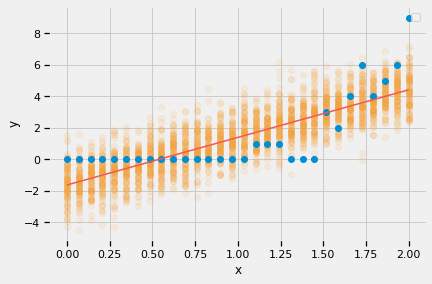

In [294]:
lambdas = results_norm_eq.position[0] + results_norm_eq.position[1] * xx

n = 100
samples = np.add(tfd.Normal(loc=lambdas, scale=1).sample(n), np.random.uniform(-0.5, 0.5, size=(n, 30)))
print(samples.shape)

for sample in samples:
    plt.scatter(xx, sample, c=TFColor[1], alpha=0.1, marker="o")
plt.scatter(xx, yy)
plt.plot(xx, lambdas, c=TFColor[0])
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### ポワソン分布　＆　対数関数

In [238]:
@make_val_and_grad_fn
def logl(x):
    mean = tf.exp(x[0] + x[1] * xx)
    dist = tfd.Poisson(rate=mean)
    logl = -tf.reduce_sum(dist.log_prob(yy))
    return logl

dim = 2

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results_poison_log = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results_poison_log.converged)
print('Location of the minimum:', results_poison_log.position) 
print('Number of iterations:', results_poison_log.num_iterations)
print("objective_value:", results_poison_log.objective_value)

Evaluation took: 0.020464 seconds
L-BFGS Results
From: [0.90082887 0.6126283 ]
Converged: True
Location of the minimum: [-5.2732406  3.7683382]
Number of iterations: 11
objective_value: 23.168354


(100, 30)


No handles with labels found to put in legend.


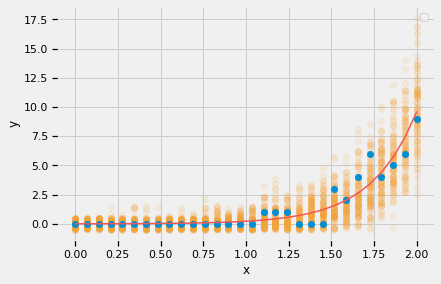

In [293]:
lambdas = np.exp(results_poison_log.position[0] + results_poison_log.position[1] * xx)

n = 100
samples = np.add(tfd.Poisson(rate=lambdas).sample(n), np.random.uniform(-0.5, 0.5, size=(n, 30)))
print(samples.shape)

for sample in samples:
    plt.scatter(xx, sample, c=TFColor[1], alpha=0.1, marker="o")
plt.scatter(xx, yy)
plt.plot(xx, lambdas, c=TFColor[0])
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### 試しにtfp.glm

In [256]:
x = np.expand_dims(xx, axis=1)
y = yy
print(x.shape)
print(y.shape)

(30, 1)
(30,)


In [296]:

# model_matrix: (Batch of) float-like, matrix-shaped Tensor where each row represents a sample's features.
# response    : (Batch of) vector-shaped Tensor where each element represents a sample's observed response (to the corresponding row of features). Must have same dtype as model_matrix.
@tf.function(autograph=False)
def fit_model():
  model_coefficients, linear_response, is_converged, num_iter = tfp.glm.fit(
      model_matrix=x, response=y, model=tfp.glm.Poisson())
  log_likelihood = tfp.glm.Poisson().log_prob(y, linear_response)
  return (model_coefficients, linear_response, is_converged, num_iter,
          log_likelihood)

[model_coefficients, linear_response, is_converged, num_iter, log_likelihood] = [t.numpy() for t in fit_model()]          
# model_coefficients       : (Batch of) vector-shaped Tensor; represents the fitted model coefficients, one for each column in model_matrix.
# predicted_linear_response: response-shaped Tensor representing linear predictions based on new model_coefficients, i.e., tf.linalg.matvec(model_matrix, model_coefficients) + offset. 

print(('is_converged: {}\n'
       '    num_iter: {}\n'
       '    accuracy: {}\n'
       '    deviance: {}'
      ).format(
    is_converged,
    num_iter,
    np.mean((linear_response > 0.) == y),
    2. * np.mean(log_likelihood)
    ))

is_converged: True
    num_iter: 6
    accuracy: 0.13333333333333333
    deviance: -3.5459670564296677


In [300]:
linear_response

array([0.        , 0.04388122, 0.08776244, 0.13164366, 0.17552488,
       0.2194061 , 0.26328731, 0.30716853, 0.35104975, 0.39493097,
       0.43881219, 0.48269341, 0.52657463, 0.57045585, 0.61433707,
       0.65821829, 0.70209951, 0.74598072, 0.78986194, 0.83374316,
       0.87762438, 0.9215056 , 0.96538682, 1.00926804, 1.05314926,
       1.09703048, 1.1409117 , 1.18479292, 1.22867414, 1.27255535])

In [298]:
model_coefficients

array([0.63627768])

No handles with labels found to put in legend.


(100, 30)


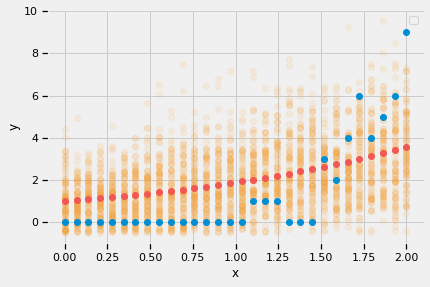

In [302]:
lambdas = np.exp(linear_response)

n = 100
samples = np.add(tfd.Poisson(rate=lambdas).sample(n), np.random.uniform(-0.5, 0.5, size=(n, 30)))
print(samples.shape)

for sample in samples:
    plt.scatter(xx, sample, c=TFColor[1], alpha=0.1, marker="o")
plt.scatter(xx, yy)
plt.scatter(xx, lambdas, c=TFColor[0])
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()